In [8]:
# Training the model on 30k datasets.
# Before training add "env": {"PYTHONHASHSEED":"0"} to kernel.json file
# Use `jupyter kernelspec list` to see a list of installed kernels
# For more info see: 
# https://stackoverflow.com/questions/58067359/is-there-a-way-to-set-pythonhashseed-for-a-jupyter-notebook-session

import os
import pickle

import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import roc_auc_score, roc_curve

from constants import experiment_set, protein_list, protein_names
from utils import get_class, get_model, load_data_sources, reset_seeds

# Set random seeds for reproducibility.

reset_seeds()

# When running on a GPU, some operations have non-deterministic outputs.
# Force the code to run on a single core of the CPU.
session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1, inter_op_parallelism_threads=1
)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)


/home/alovse/miniconda3/envs/rnap3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/alovse/miniconda3/envs/rnap3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/alovse/miniconda3/envs/rnap3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/alovse/miniconda3/envs/rnap3/lib/python3

In [4]:
# TRAIN
average_score = np.zeros(len(protein_list))

for training_set_number in range(3):
    reset_seeds()
    score_list = []

    if not os.path.exists("results/set_%s" % training_set_number):
        os.makedirs("results/set_%s" % training_set_number)

    for protein in protein_list:
        reset_seeds()

        if not os.path.exists("results/set_%s/%s" % (training_set_number, protein)):
            os.makedirs("results/set_%s/%s" % (training_set_number, protein))

        print(protein)

        data_sources, X = load_data_sources(
            protein, "train", training_set_number, *experiment_set
        )
        y = get_class(protein, "train", training_set_number)
        size = X.shape[2]
        score = []

        model = get_model(size)

        model.compile(
            loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
        )

        checkpointer = ModelCheckpoint(
            filepath=f"results/set_{training_set_number}/{protein}/weights.h5",
            verbose=1,
            save_best_only=True,
        )
        earlystopper = EarlyStopping(monitor="val_loss", patience=5, verbose=1)
        metrics = model.fit(
            X,
            y,
            validation_split=0.2,
            epochs=12,
            batch_size=200,
            verbose=1,
            callbacks=[earlystopper, checkpointer],
        )

        # Save score list
        with open(
            "results/set_%s/%s/score" % (training_set_number, protein), "w"
        ) as score_file:
            np.save(("results/set_%s/%s/score" % (training_set_number, protein)), score)

        # Save model
        json_model = model.to_json()
        with open(
            "results/set_%s/%s/model.json" % (training_set_number, protein), "w"
        ) as json_file:
            json_file.write(json_model)

        # Save the model metrics generated with model fit.
        with open(
            "results/set_%s/%s/metrics" % (training_set_number, protein), "wb"
        ) as pickle_file:
            pickle.dump(metrics, pickle_file, protocol=pickle.HIGHEST_PROTOCOL)



1_PARCLIP_AGO1234_hg19
Train on 24000 samples, validate on 6000 samples
Epoch 1/12
24000/24000 [==============================] - 12s 519us/step - loss: 0.3444 - acc: 0.8613 - val_loss: 0.3033 - val_acc: 0.8823

Epoch 00001: val_loss improved from inf to 0.30332, saving model to results/set_0/1_PARCLIP_AGO1234_hg19/weights.h5
Epoch 2/12
24000/24000 [==============================] - 13s 521us/step - loss: 0.2467 - acc: 0.9042 - val_loss: 0.2957 - val_acc: 0.8867

Epoch 00002: val_loss improved from 0.30332 to 0.29572, saving model to results/set_0/1_PARCLIP_AGO1234_hg19/weights.h5
Epoch 3/12
24000/24000 [==============================] - 14s 580us/step - loss: 0.2378 - acc: 0.9071 - val_loss: 0.2953 - val_acc: 0.8862

Epoch 00003: val_loss improved from 0.29572 to 0.29527, saving model to results/set_0/1_PARCLIP_AGO1234_hg19/weights.h5
Epoch 4/12
24000/24000 [==============================] - 14s 595us/step - loss: 0.2315 - acc: 0.9100 - val_loss: 0.2944 - val_acc: 0.8883

Epoch 00004:

In [5]:
# TEST
from keras.models import model_from_json

# Run predictions on all 3 test datasets.
for training_set_number in range(3):
    for protein in protein_list:
        # Load the model and weights.
        with open(
            "results/set_%s/%s/model.json" % (training_set_number, protein), "r"
        ) as json_file:
            json = json_file.read()
            loaded_model = model_from_json(json)
            loaded_model.load_weights(
                "results/set_%s/%s/weights.h5" % (training_set_number, protein)
            )

        data_sources, X_test = load_data_sources(
            protein, "test", training_set_number, *experiment_set
        )
        predictions = loaded_model.predict(X_test)

        with open(
            "results/set_%s/%s/predictions" % (training_set_number, protein), "wb"
        ) as predictions_file:
            np.save(predictions_file, predictions)



1_PARCLIP_AGO1234_hg19


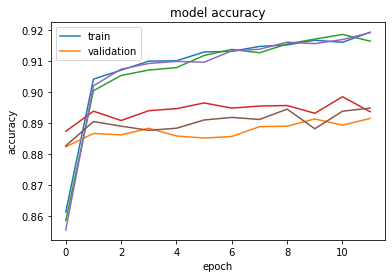

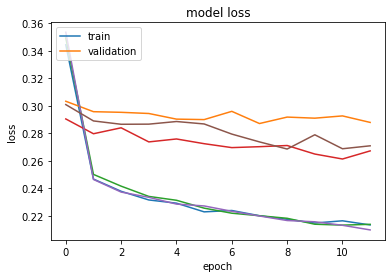

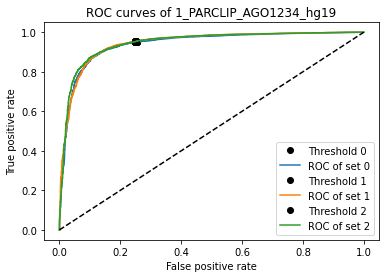

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 1_PARCLIP_AGO1234_hg19, with the average AUC of 0.9429755833333333 ([0.93984916 0.94358472 0.94549288]) across all three datasets.
2_PARCLIP_AGO2MNASE_hg19


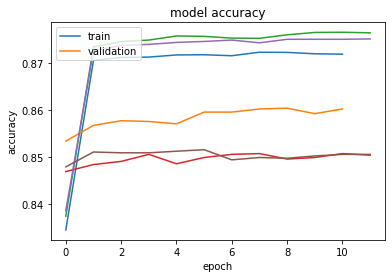

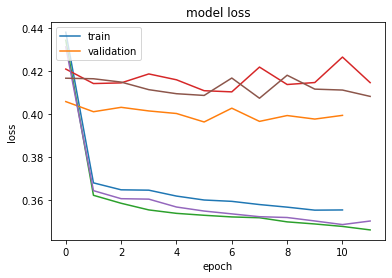

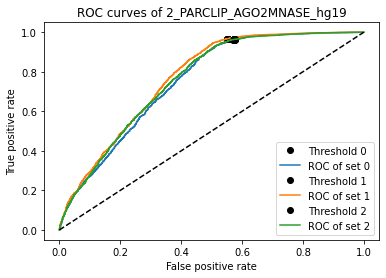

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 2_PARCLIP_AGO2MNASE_hg19, with the average AUC of 0.7607984895833333 ([0.75228766 0.76977156 0.76033625]) across all three datasets.
3_HITSCLIP_Ago2_binding_clusters


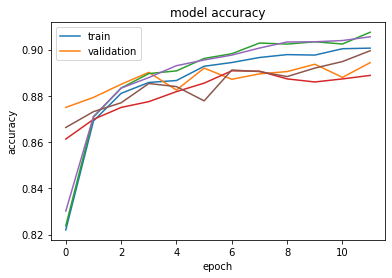

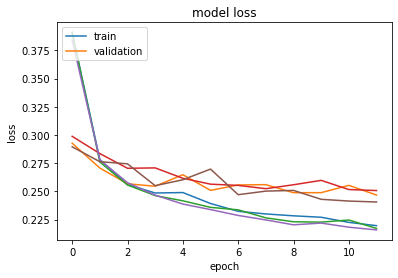

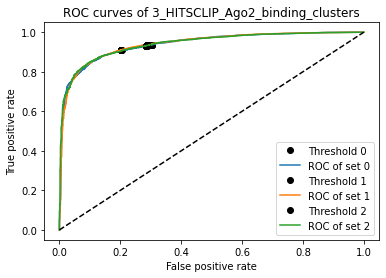

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 3_HITSCLIP_Ago2_binding_clusters, with the average AUC of 0.9400625729166667 ([0.93928725 0.93980166 0.94109881]) across all three datasets.
4_HITSCLIP_Ago2_binding_clusters_2


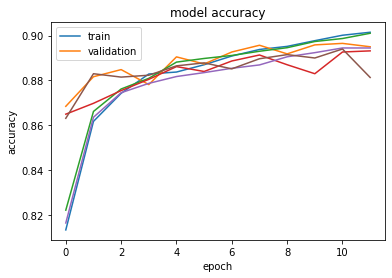

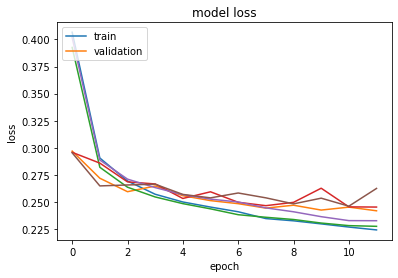

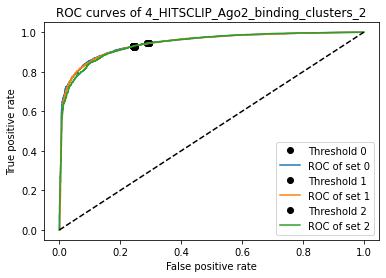

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 4_HITSCLIP_Ago2_binding_clusters_2, with the average AUC of 0.9436449583333335 ([0.94517813 0.94367941 0.94207734]) across all three datasets.
5_CLIPSEQ_AGO2_hg19


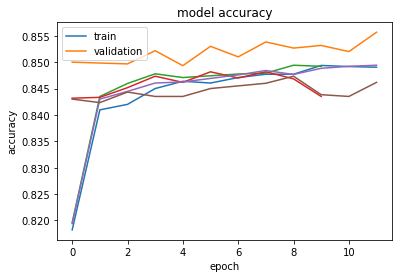

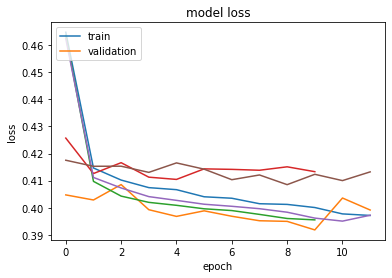

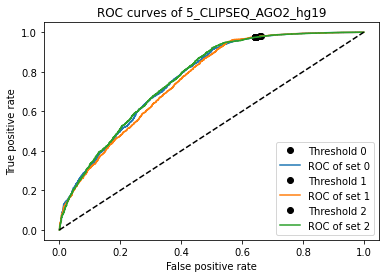

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 5_CLIPSEQ_AGO2_hg19, with the average AUC of 0.7644596250000001 ([0.76709887 0.75690694 0.76937306]) across all three datasets.
6_CLIP-seq-eIF4AIII_1


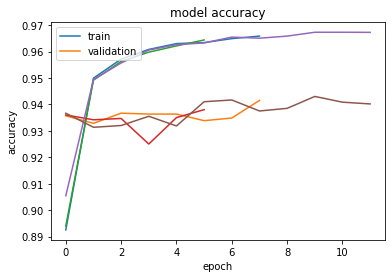

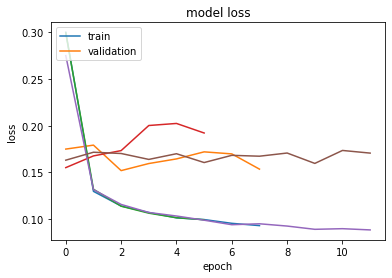

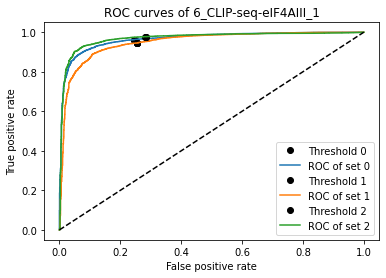

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 6_CLIP-seq-eIF4AIII_1, with the average AUC of 0.9611301458333332 ([0.96517025 0.94898834 0.96923184]) across all three datasets.
7_CLIP-seq-eIF4AIII_2


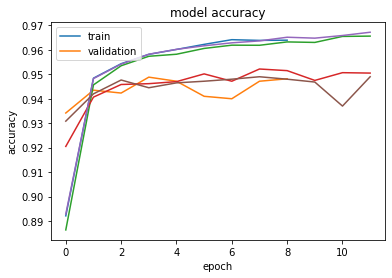

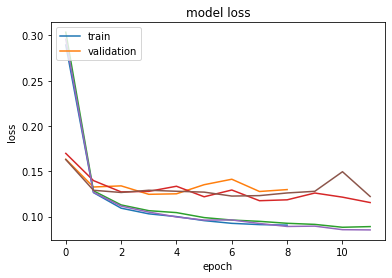

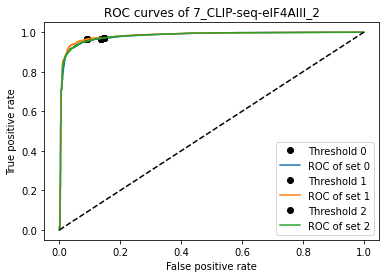

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 7_CLIP-seq-eIF4AIII_2, with the average AUC of 0.98156328125 ([0.98075163 0.98251916 0.98141906]) across all three datasets.
8_PARCLIP_ELAVL1_hg19


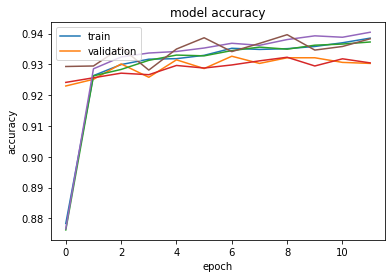

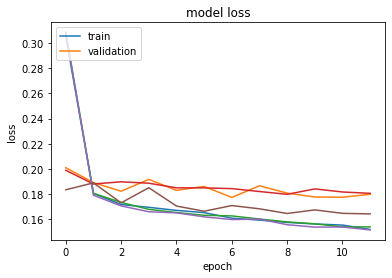

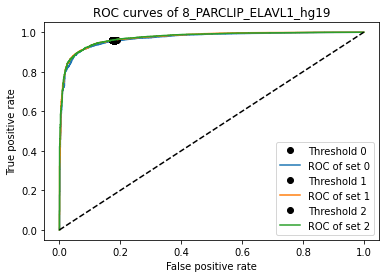

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 8_PARCLIP_ELAVL1_hg19, with the average AUC of 0.97162353125 ([0.96895869 0.97285234 0.97305956]) across all three datasets.
9_PARCLIP_ELAVL1MNASE_hg19


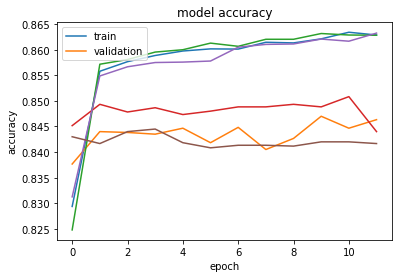

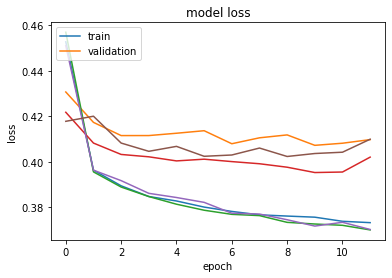

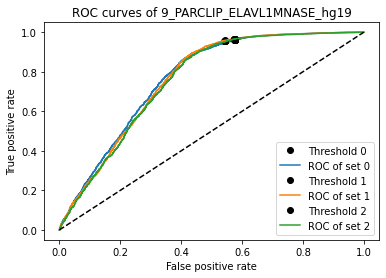

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 9_PARCLIP_ELAVL1MNASE_hg19, with the average AUC of 0.7626997083333333 ([0.76792322 0.76303369 0.75714222]) across all three datasets.
10_PARCLIP_ELAVL1A_hg19


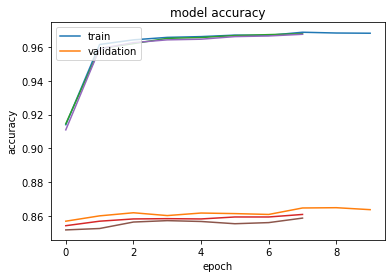

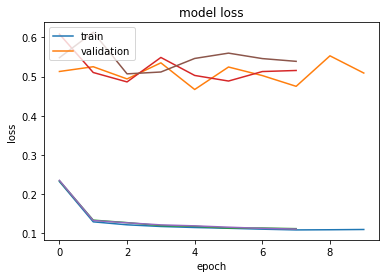

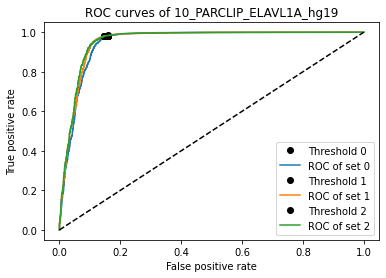

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 10_PARCLIP_ELAVL1A_hg19, with the average AUC of 0.95275796875 ([0.94906753 0.953617   0.95558937]) across all three datasets.
11_CLIPSEQ_ELAVL1_hg19


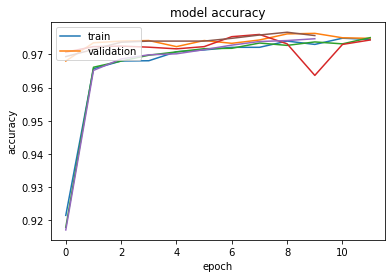

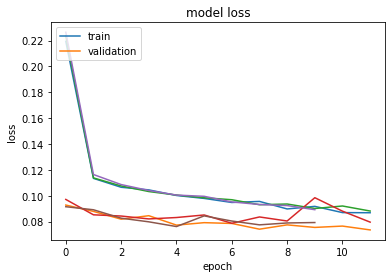

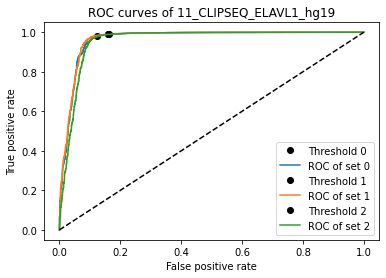

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 11_CLIPSEQ_ELAVL1_hg19, with the average AUC of 0.9623557083333335 ([0.96459941 0.96609453 0.95637319]) across all three datasets.
12_PARCLIP_EWSR1_hg19


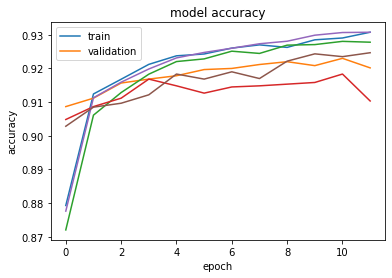

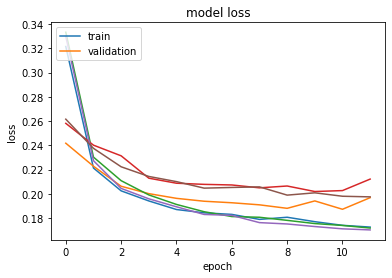

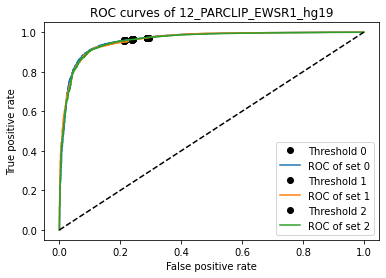

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 12_PARCLIP_EWSR1_hg19, with the average AUC of 0.9602608125000001 ([0.96106775 0.96054053 0.95917416]) across all three datasets.
13_PARCLIP_FUS_hg19


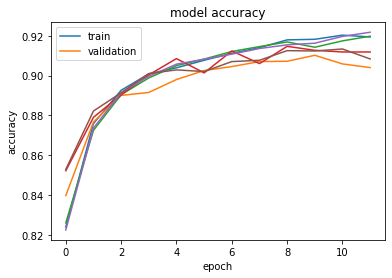

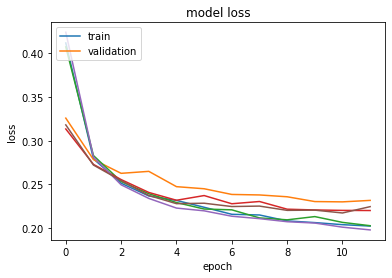

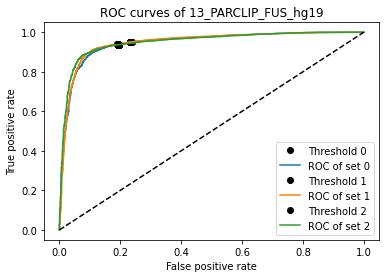

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 13_PARCLIP_FUS_hg19, with the average AUC of 0.9477526354166667 ([0.94586606 0.94750409 0.94988775]) across all three datasets.
14_PARCLIP_FUS_mut_hg19


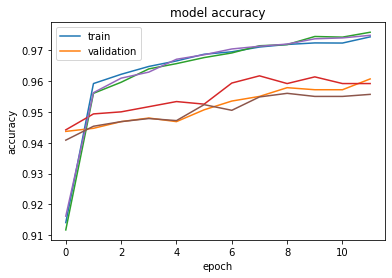

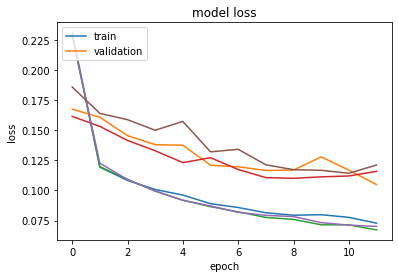

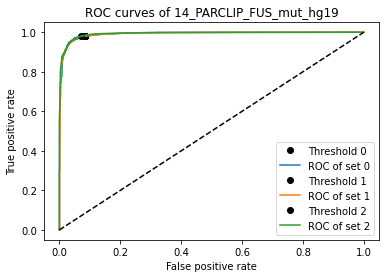

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 14_PARCLIP_FUS_mut_hg19, with the average AUC of 0.9917874375000001 ([0.99146053 0.99115653 0.99274525]) across all three datasets.
15_PARCLIP_IGF2BP123_hg19


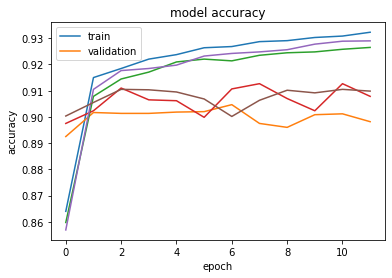

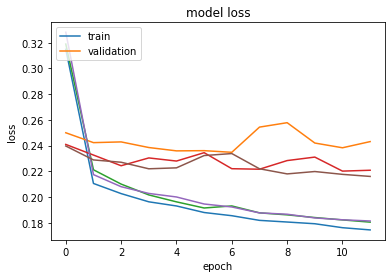

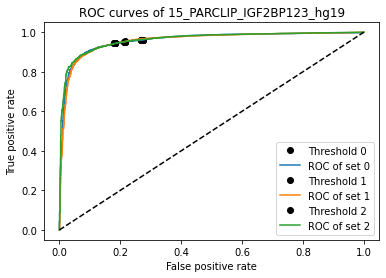

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 15_PARCLIP_IGF2BP123_hg19, with the average AUC of 0.9586796354166666 ([0.95806209 0.9564375  0.96153931]) across all three datasets.
16_ICLIP_hnRNPC_Hela_iCLIP_all_clusters


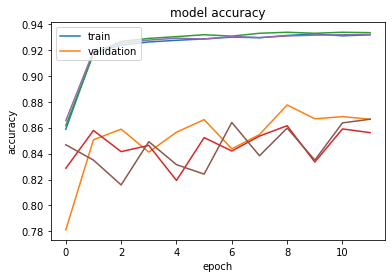

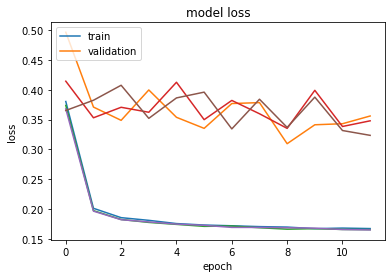

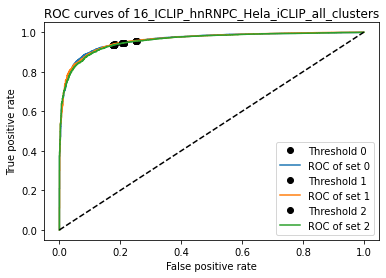

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 16_ICLIP_hnRNPC_Hela_iCLIP_all_clusters, with the average AUC of 0.9592611562500001 ([0.96002759 0.95991019 0.95784569]) across all three datasets.
17_ICLIP_HNRNPC_hg19


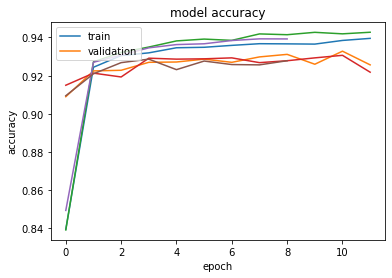

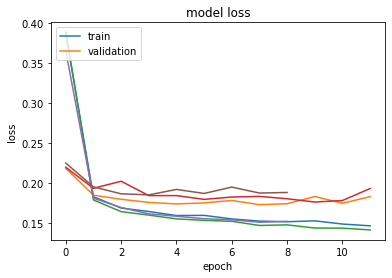

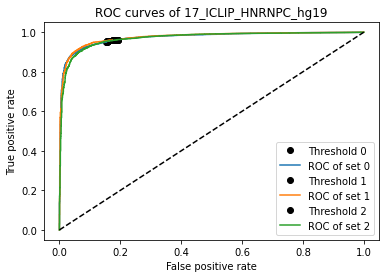

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 17_ICLIP_HNRNPC_hg19, with the average AUC of 0.9721336458333333 ([0.97261731 0.97415956 0.96962406]) across all three datasets.
18_ICLIP_hnRNPL_Hela_group_3975_all-hnRNPL-Hela-hg19_sum_G_hg19--ensembl59_from_2337-2339-741_bedGraph-cDNA-hits-in-genome


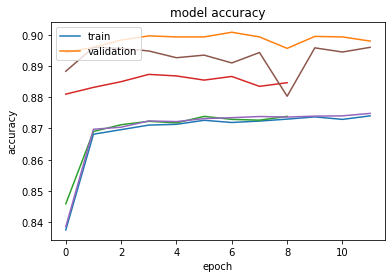

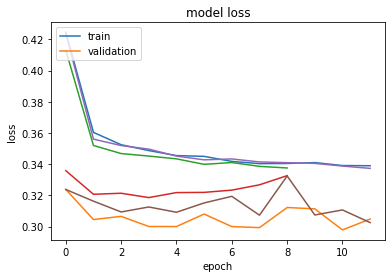

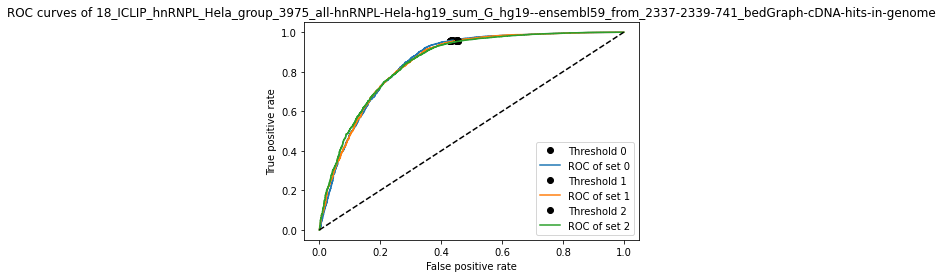

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 18_ICLIP_hnRNPL_Hela_group_3975_all-hnRNPL-Hela-hg19_sum_G_hg19--ensembl59_from_2337-2339-741_bedGraph-cDNA-hits-in-genome, with the average AUC of 0.85088228125 ([0.85042028 0.8503855  0.85184106]) across all three datasets.
19_ICLIP_hnRNPL_U266_group_3986_all-hnRNPL-U266-hg19_sum_G_hg19--ensembl59_from_2485_bedGraph-cDNA-hits-in-genome


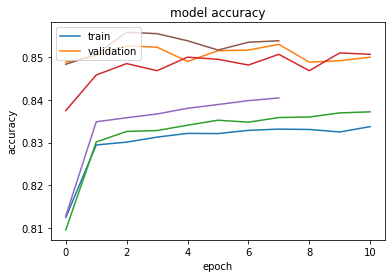

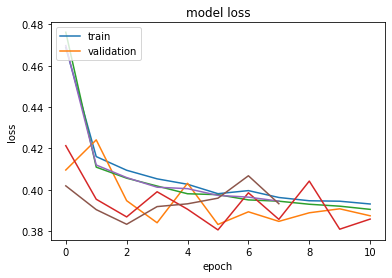

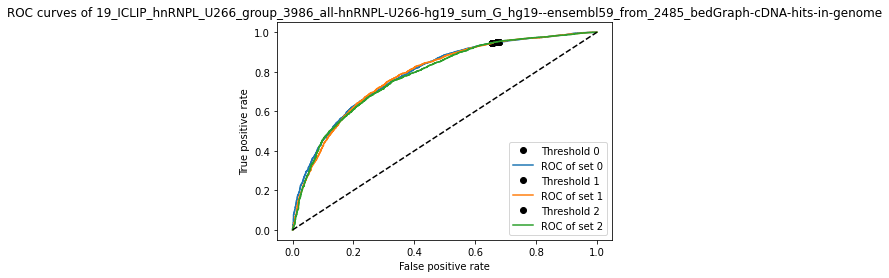

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 19_ICLIP_hnRNPL_U266_group_3986_all-hnRNPL-U266-hg19_sum_G_hg19--ensembl59_from_2485_bedGraph-cDNA-hits-in-genome, with the average AUC of 0.7882727916666666 ([0.7922045  0.78847563 0.78413825]) across all three datasets.
20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_G_hg19--ensembl59_from_2342-2486_bedGraph-cDNA-hits-in-genome


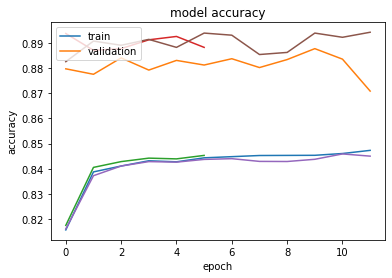

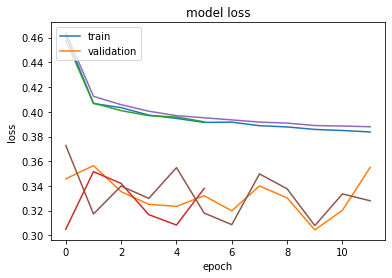

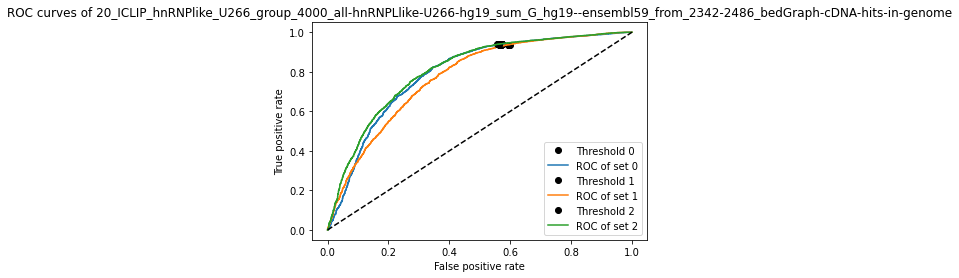

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_G_hg19--ensembl59_from_2342-2486_bedGraph-cDNA-hits-in-genome, with the average AUC of 0.7907404374999999 ([0.79282375 0.77305316 0.80634441]) across all three datasets.
21_PARCLIP_MOV10_Sievers_hg19


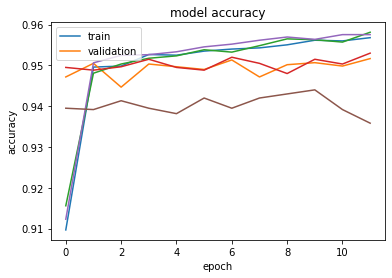

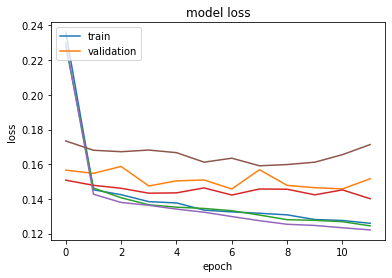

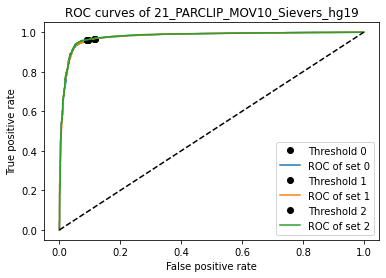

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 21_PARCLIP_MOV10_Sievers_hg19, with the average AUC of 0.9773970416666667 ([0.97720019 0.97712947 0.97786147]) across all three datasets.
22_ICLIP_NSUN2_293_group_4007_all-NSUN2-293-hg19_sum_G_hg19--ensembl59_from_3137-3202_bedGraph-cDNA-hits-in-genome


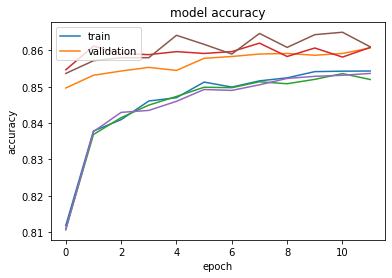

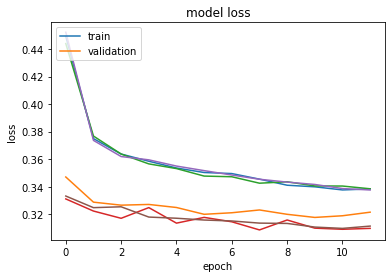

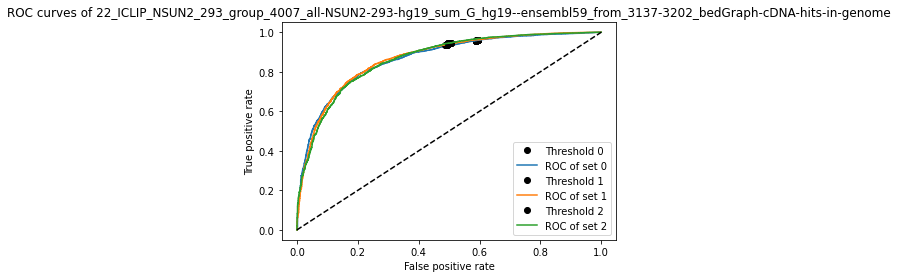

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 22_ICLIP_NSUN2_293_group_4007_all-NSUN2-293-hg19_sum_G_hg19--ensembl59_from_3137-3202_bedGraph-cDNA-hits-in-genome, with the average AUC of 0.866070625 ([0.86547672 0.868174   0.86456116]) across all three datasets.
23_PARCLIP_PUM2_hg19


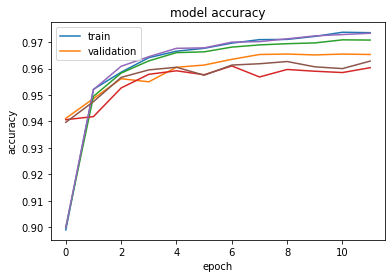

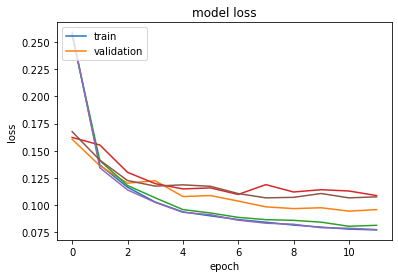

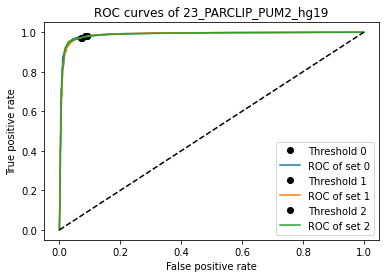

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 23_PARCLIP_PUM2_hg19, with the average AUC of 0.9878565520833335 ([0.98880366 0.98751784 0.98724816]) across all three datasets.
24_PARCLIP_QKI_hg19


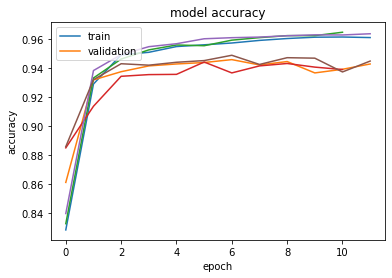

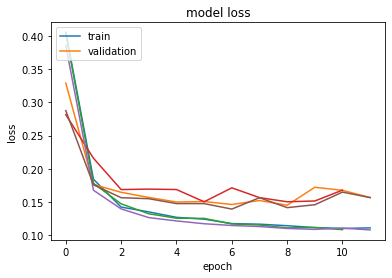

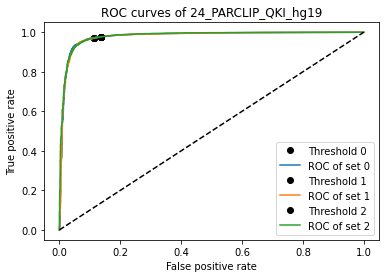

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 24_PARCLIP_QKI_hg19, with the average AUC of 0.9787425104166667 ([0.97816591 0.97756491 0.98049672]) across all three datasets.
25_CLIPSEQ_SFRS1_hg19


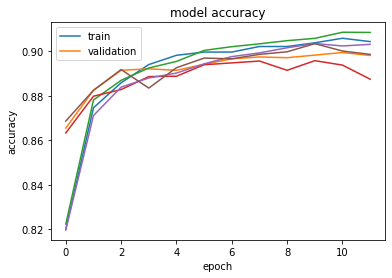

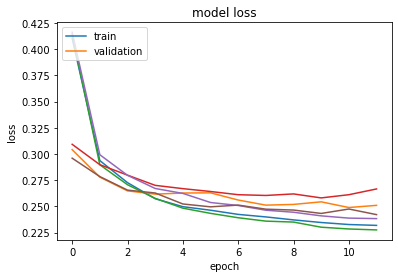

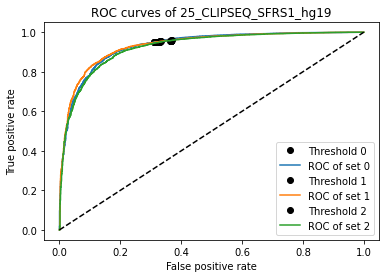

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 25_CLIPSEQ_SFRS1_hg19, with the average AUC of 0.9296568020833335 ([0.93093797 0.93332894 0.9247035 ]) across all three datasets.
26_PARCLIP_TAF15_hg19


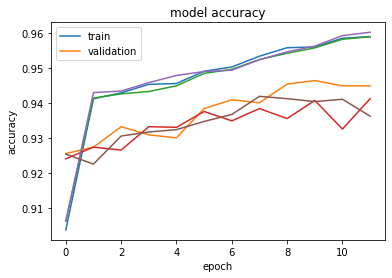

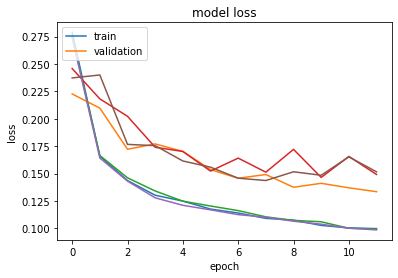

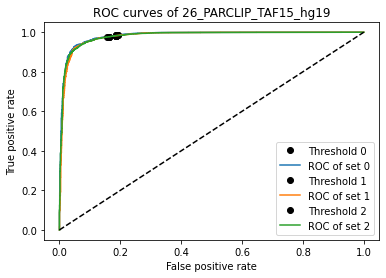

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 26_PARCLIP_TAF15_hg19, with the average AUC of 0.9806072604166669 ([0.98240397 0.97883031 0.9805875 ]) across all three datasets.
27_ICLIP_TDP43_hg19


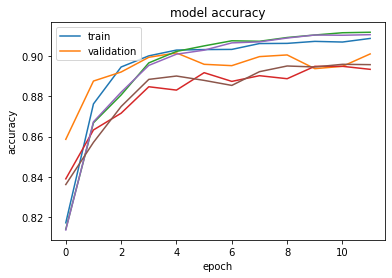

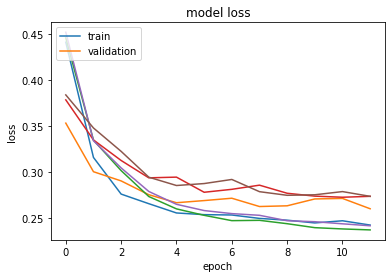

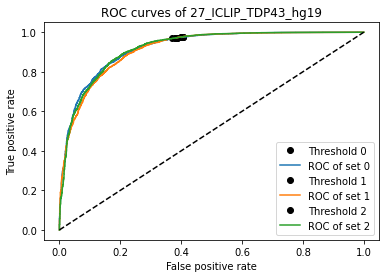

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 27_ICLIP_TDP43_hg19, with the average AUC of 0.9187304895833334 ([0.92112713 0.91549497 0.91956938]) across all three datasets.
28_ICLIP_TIA1_hg19


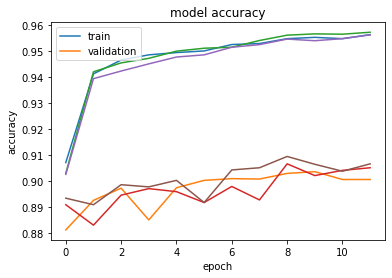

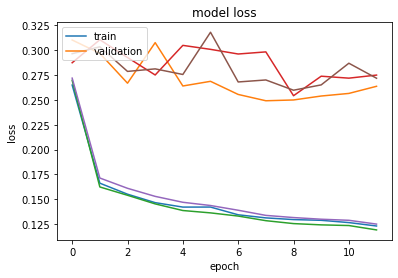

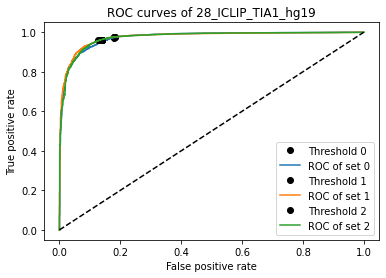

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 28_ICLIP_TIA1_hg19, with the average AUC of 0.9738779375000001 ([0.97306403 0.97516287 0.97340691]) across all three datasets.
29_ICLIP_TIAL1_hg19


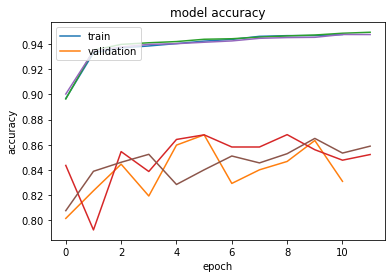

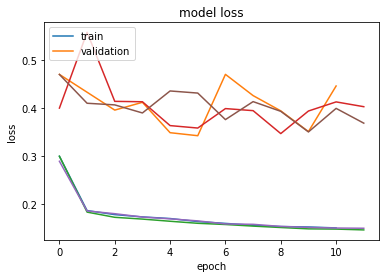

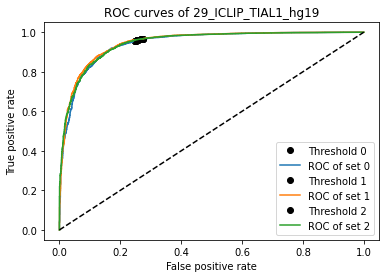

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 29_ICLIP_TIAL1_hg19, with the average AUC of 0.9451481875000001 ([0.94261475 0.94727428 0.94555553]) across all three datasets.
30_ICLIP_U2AF65_Hela_iCLIP_ctrl_all_clusters


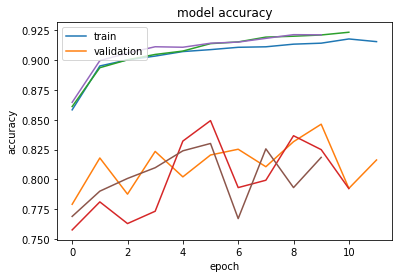

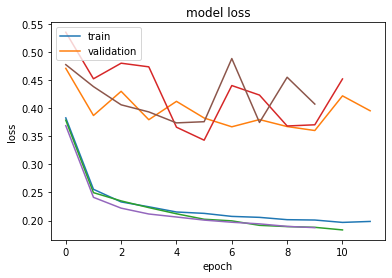

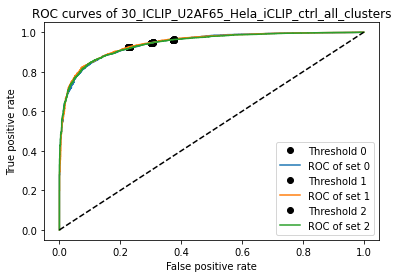

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 30_ICLIP_U2AF65_Hela_iCLIP_ctrl_all_clusters, with the average AUC of 0.9435015312499999 ([0.94309838 0.94447434 0.94293187]) across all three datasets.
31_ICLIP_U2AF65_Hela_iCLIP_ctrl+kd_all_clusters


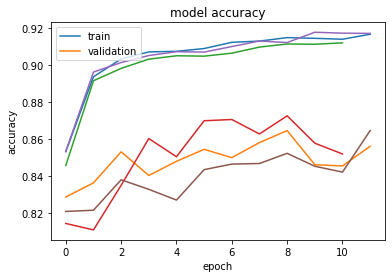

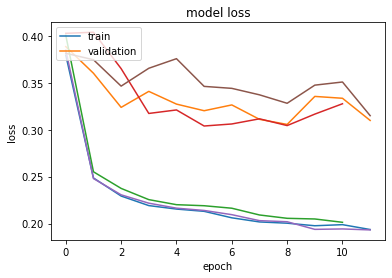

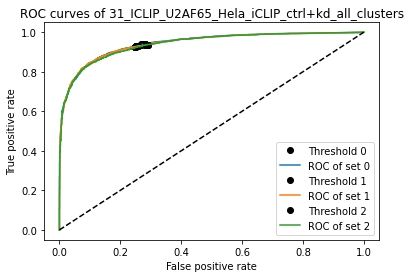

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 31_ICLIP_U2AF65_Hela_iCLIP_ctrl+kd_all_clusters, with the average AUC of 0.9418175833333334 ([0.94308631 0.94239625 0.93997019]) across all three datasets.


In [9]:
# Plot accuracy, loss values and ROC.
if not os.path.exists("results/ROC"):
    os.makedirs("results/ROC")

scores_dict = {}
for protein in protein_list:
    average_score = np.zeros(3)
    print(protein)

    for training_set_number in range(3):
        # Load the model metrics generated with model fit.

        with open(
            "results/set_%s/%s/metrics" % (training_set_number, protein), "rb"
        ) as pickle_file:
            metrics = pickle.load(pickle_file, encoding="latin1")

            # Plot history for accuracy.
            plt.figure(1)
            plt.plot(metrics.history["acc"])
            plt.plot(metrics.history["val_acc"])
            plt.title("model accuracy")
            plt.ylabel("accuracy")
            plt.xlabel("epoch")
            plt.legend(["train", "validation"], loc="upper left")

            # Plot loss function history.
            plt.figure(2)
            plt.plot(metrics.history["loss"])
            plt.plot(metrics.history["val_loss"])
            plt.title("model loss")
            plt.ylabel("loss")
            plt.xlabel("epoch")
            plt.legend(["train", "validation"], loc="upper left")

        # Load model predictions.
        with open(
            "results/set_%s/%s/predictions" % (training_set_number, protein), "rb"
        ) as predictions_file:
            loaded_predictions = np.load(predictions_file)

            # Evaluate model performance.
            y_scores = loaded_predictions[:, 0:1]
            y_test = get_class(protein, "test", training_set_number)
            y_test = y_test[:, 0:1]

            # Find where the threshold is equal to 0.5
            score = roc_auc_score(y_test, y_scores)
            fpr, tpr, thresholds = roc_curve(y_test, y_scores)
            thresholds = np.round(thresholds, 2)
            t_index = np.where(thresholds == 0.50)[0]

            # ROC plot
            plt.figure(3)
            plt.plot(
                fpr[t_index],
                tpr[t_index],
                "ok",
                label="Threshold {}".format(training_set_number),
            )
            plt.plot(fpr, tpr, label="ROC of set {}".format(training_set_number))

        average_score[training_set_number] = score

    scores_dict[protein] = np.mean(average_score)
    plt.figure(3)
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.title(f"ROC curves of {protein}")
    plt.legend(loc="best")
    plt.savefig("results/ROC/{}.png".format(protein))
    plt.show()
    print(
        f"Plots of accuracy, loss function during traing and a ROC curve of model's predictions on {protein}, "
        f"with the average AUC of {np.mean(average_score)} ({average_score}) across all three datasets."
    )
    plt.close("all")



1_PARCLIP_AGO1234_hg19


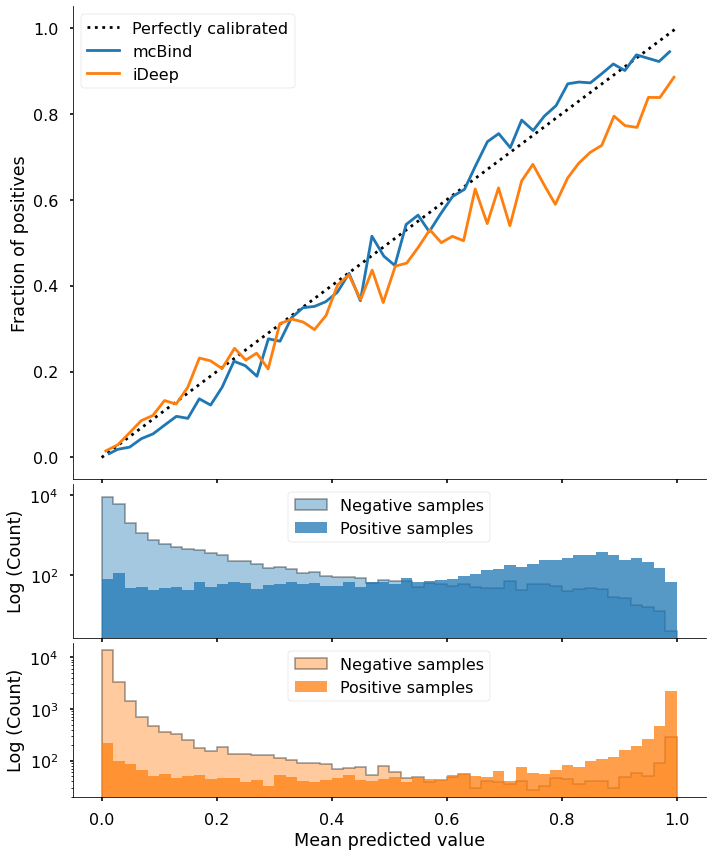

In [7]:
from sklearn.calibration import calibration_curve

if not os.path.exists("results/calibration_curves"):
    os.makedirs("results/calibration_curves")

for protein in protein_list:
    average_score = np.zeros(3)
    print(protein)
    complete_ideep_prediction = []
    y_scores = []
    total_y_test = []

    for training_set_number in range(3):
        # Load model predictions.
        with open(
            "results/set_%s/%s/predictions" % (training_set_number, protein), "rb"
        ) as predictions_file, open(
            "ideep_results/predictions%s/%s" % (training_set_number, protein), "r"
        ) as ideep_file:
            loaded_predictions = np.load(predictions_file, encoding="bytes")
            ideep_prediction = np.loadtxt(ideep_file, delimiter="\n", unpack=False)
            ideep_prediction = np.array(ideep_prediction)
            complete_ideep_prediction = np.append(
                complete_ideep_prediction, ideep_prediction
            )
            # Evaluate model performance.
            y_scores = np.append(y_scores, loaded_predictions[:, 1])
            y_test = get_class(protein, "test", training_set_number)
            total_y_test = np.append(total_y_test, y_test[:, 1])
    
    y_scores.flatten()
    total_y_test.flatten()
    complete_ideep_prediction.flatten()
    fraction_of_positives, mean_predicted_value = calibration_curve(
        total_y_test, y_scores, n_bins=50
    )
    ideep_frp, ideep_mpv = calibration_curve(
        total_y_test, complete_ideep_prediction, n_bins=50
    )

    style.use("seaborn-poster")
    fig = plt.figure(figsize=(10, 12))
    ax1 = plt.subplot2grid((5, 1), (0, 0), rowspan=3)
    ax2 = plt.subplot2grid((5, 1), (3, 0), sharex=ax1)
    ax3 = plt.subplot2grid((5, 1), (4, 0), sharex=ax1)

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    ax1.plot(mean_predicted_value, fraction_of_positives, label="mcBind")
    ax1.plot(ideep_mpv, ideep_frp, label="iDeep")
    ax1.set_ylabel("Fraction of positives")
    ax1.legend(loc="upper left")

    ax2.hist(
        y_scores[total_y_test == 0],
        range=(0, 1),
        bins=50,
        histtype="stepfilled",
        label="Negative samples",
        alpha=0.4,
        color="tab:blue",
        edgecolor="#04080d",
        linewidth=1.5,
    )
    ax2.hist(
        y_scores[total_y_test == 1],
        range=(0, 1),
        bins=50,
        histtype="stepfilled",
        label="Positive samples",
        alpha=0.75,
        color="tab:blue",
    )

    ax3.hist(
        complete_ideep_prediction[total_y_test == 0],
        range=(0, 1),
        bins=50,
        histtype="stepfilled",
        lw=2,
        label="Negative samples",
        alpha=0.4,
        color="tab:orange",
        edgecolor="black",
        linewidth=1.5,
    )
    ax3.hist(
        complete_ideep_prediction[total_y_test == 1],
        range=(0, 1),
        bins=50,
        histtype="stepfilled",
        lw=2,
        label="Positive samples",
        alpha=0.75,
        color="tab:orange",
    )

    ax2.legend(loc="upper center")
    ax3.legend(loc="upper center")
    ax2.set_ylabel("Log (Count)")
    ax2.set_yscale("log")
    ax3.set_ylabel("Log (Count)")
    ax3.set_xlabel("Mean predicted value")
    ax3.set_yscale("log")

    top_max = max(ax2.get_ylim()[1], ax3.get_ylim()[1])

    ax2.set_ylim(top=top_max)
    ax3.set_ylim(top=top_max)

    fig.tight_layout()
    fig.subplots_adjust(hspace=0.03)

    for ax in [ax1, ax2, ax3]:
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

    plt.savefig("results/calibration_curves/{}_calibration_curve.png".format(protein))
    plt.show()
    plt.close()


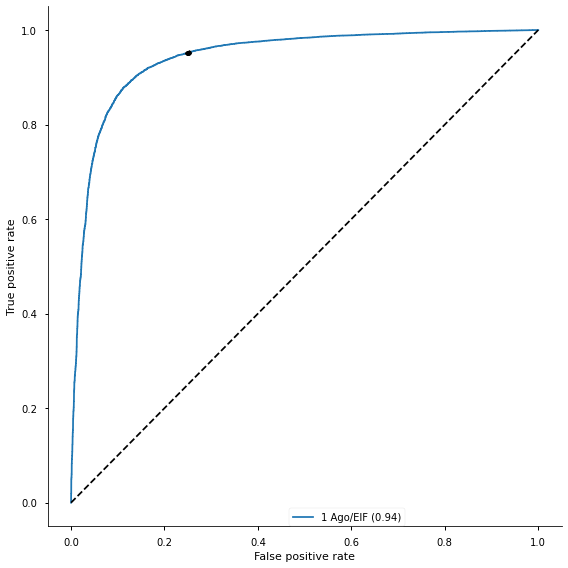

In [8]:
style.use("seaborn-notebook")

fig, ax = plt.subplots(figsize=(8, 8))
for protein, name in zip(protein_list, protein_names):
    complete_y_test = None
    complete_y_scores = None
    for training_set_number in range(3):
        # Load model predictions.
        with open(
            "results/set_%s/%s/predictions" % (training_set_number, protein), "rb"
        ) as predictions_file:
            loaded_predictions = np.load(predictions_file)

            if complete_y_test is not None:
                complete_y_test = np.append(
                    complete_y_test,
                    get_class(protein, "test", training_set_number)[:, 0:1],
                )
            else:
                complete_y_test = get_class(protein, "test", training_set_number)[
                    :, 0:1
                ]

            if complete_y_scores is not None:
                complete_y_scores = np.append(
                    complete_y_scores, loaded_predictions[:, 0:1]
                )
            else:
                complete_y_scores = loaded_predictions[:, 0:1]
    fpr, tpr, thresholds = roc_curve(complete_y_test, complete_y_scores)

    thresholds = np.round(thresholds, 2)
    t_index = np.where(thresholds == 0.50)[0]
    ax.plot(fpr, tpr, label=f"{name} ({round(scores_dict[protein], 2)})")
    ax.plot(fpr[t_index], tpr[t_index], ".k")

ax.plot([0, 1], [0, 1], "k--")
ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")
ax.spines["top"].set_color("none")
ax.spines["right"].set_color("none")
handles, labels = ax.get_legend_handles_labels()

# sort both labels and handles by labels
auc, labels, handles = zip(
    *sorted(zip(scores_dict.values(), labels, handles), key=lambda t: t[0])
)
ax.legend(handles[::-1], labels[::-1], loc=[0.47, 0], ncol=2)
plt.tight_layout()
plt.savefig("results/combined_ROC.svg")
plt.show()


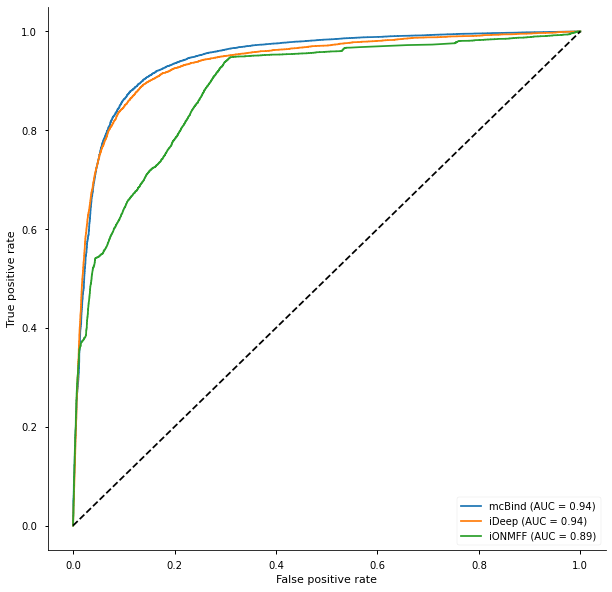

In [9]:
if not os.path.exists("results/ROC_all"):
    os.makedirs("results/ROC_all")

for protein in protein_list:
    for training_set_number in range(3):
        with open("results/set_%s/%s/predictions" % (training_set_number, protein), "rb") as predictions_file:
            loaded_predictions = np.load(predictions_file)
        with open("../../iONMF/results/set_%s/%s_predictions" % (training_set_number, protein), "rb") as ionmf_file:
            ionmf_loaded = np.load(ionmf_file)
        ideep_loaded = np.loadtxt(
            f"../../iDeep/predictions_{training_set_number}/{protein}", delimiter="\n", unpack=False)
        y_test = get_class(protein, "test", training_set_number)

        if training_set_number == 0:
            imcnn_predictions = loaded_predictions[:, 0:1]
            imcnn_test = y_test[:, 0:1]
            ideep_predictions = ideep_loaded
            ideep_test = y_test[:, 1]
            ionmf_predictions = ionmf_loaded

        else:
            imcnn_predictions = np.concatenate(
                (imcnn_predictions, loaded_predictions[:, 0:1]))
            imcnn_test = np.concatenate((imcnn_test, y_test[:, 0:1]))
            ideep_predictions = np.concatenate(
                (ideep_predictions, ideep_loaded))
            ideep_test = np.concatenate((ideep_test, y_test[:, 1]))
            ionmf_predictions = np.concatenate(
                (ionmf_predictions, ionmf_loaded))

    imcnn_fpr, imcnn_tpr, _ = roc_curve(imcnn_test, imcnn_predictions)
    ideep_fpr, ideep_tpr, _ = roc_curve(ideep_test, ideep_predictions)
    ionmf_fpr, ionmf_tpr, _ = roc_curve(ideep_test, ionmf_predictions)

    imcnn_auc = round(roc_auc_score(imcnn_test, imcnn_predictions), 2)
    ideep_auc = round(roc_auc_score(ideep_test, ideep_predictions), 2)
    ionmf_auc = round(roc_auc_score(ideep_test, ionmf_predictions), 2)
    
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.plot(imcnn_fpr, imcnn_tpr, label=f'mcBind (AUC = {imcnn_auc})')
    ax.plot(ideep_fpr, ideep_tpr, label=f'iDeep (AUC = {ideep_auc})')
    ax.plot(ionmf_fpr, ionmf_tpr, label=f'iONMFF (AUC = {ionmf_auc})')

    ax.plot([0, 1], [0, 1], 'k--')
    ax.legend(loc='lower right')
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # ax.set_title('ROC curves of %s' % protein)
    plt.savefig(f"results/ROC_all/{protein}.png")

    plt.show()
    plt.close()

In [10]:
with open("results/scores_dict.pkl" , "wb") as pkl:
    pickle.dump(scores_dict, pkl, protocol=pickle.HIGHEST_PROTOCOL)

In [101]:
def highlight_max(s):
    """Marks the series in bold."""
    is_max = s == s.max()
    return ['font-weight:bold' if v else '' for v in is_max]

def latex_highlight(x):
    is_max = x == x.max()
    return [f'\\textbf{{{np.round(val, 3)}}}' if v else np.round(val, 3) for val, v in zip(x, is_max)]
def get_ideep_scores():
    ideep_scores = {}
    for training_set in range(3):
        for protein in protein_list:
            predictions = np.loadtxt(f"ideep_results/predictions{training_set}/{protein}", delimiter="\n", unpack=False)
            predictions = np.array(predictions)

            Y_test =  get_class(protein, "test", training_set)
            Y_test = Y_test[:,1]

            score = roc_auc_score(Y_test, predictions)
            
            if protein in ideep_scores:
                ideep_scores[protein].append(score)
            else:
                ideep_scores[protein] = [score]
    return ideep_scores

ideep_scores = get_ideep_scores()
ionmf_scores = pd.read_csv("ionmf_results/ionmf_scores.tsv", sep="\t", index_col=0)

new = pd.DataFrame.from_dict(scores_dict, orient="index").reindex(protein_list).rename(columns={0:"mcBind"})
ideep = pd.DataFrame.from_dict(ideep_scores, orient="index").reindex(protein_list).mean(axis=1).rename("iDeep")
# ionmf_scores = ionmf_scores.reindex(protein_list).mean(axis=1).rename("iONMF") TODO
ionmf = ionmf_scores.reindex(protein_list).rename(columns={"0": "iONMF"})
table = new.merge(ideep, how="inner", left_index=True, right_index=True)
table = table.merge(ionmf, how="inner", left_index=True, right_index=True)

d1 = table["mcBind"] - table["iDeep"]
d2 = table["mcBind"] - table["iONMF"]

n1 = sum(1 for number in d1 if number > 0)
n2 = sum(1 for number in d2 if number > 0)

std_err = table.sem().round(3)
avg_score = table.mean().round(3)
print(f"mcBind: {avg_score['mcBind']} +- {std_err['mcBind']}")
print(f"iONMF: {avg_score['iONMF']} +- {std_err['iONMF']}")
print(f"iDeep: {avg_score['iDeep']} +- {std_err['iDeep']}")

print("Mean difference with iDeep is %s " % (np.mean(d1)))
print("Number of proteins for which our model is better: %s " % (n1))
print("Mean difference with iONMF is %s " % (np.mean(d2)))
print("Number of proteins for which our model is better: %s " % (n2))


with pd.option_context('display.precision', 3):
    html = (table.style.apply(highlight_max, axis=1))
latex_table = table.apply(latex_highlight, axis=1, result_type='expand')

html

mcBind: 0.923 +- 0.013
iONMF: 0.772 +- 0.022
iDeep: 0.907 +- 0.018
Mean difference with iDeep is 0.016253336693548396 
Number of proteins for which our model is better: 22 
Mean difference with iONMF is 0.1512628918010753 
Number of proteins for which our model is better: 31 


In [102]:
print(latex_table.to_latex(escape=False))

\begin{tabular}{lllr}
\toprule
{} &               0 &               1 &      2 \\
\midrule
1_PARCLIP_AGO1234_hg19                             &  \textbf{0.943} &           0.937 &  0.901 \\
2_PARCLIP_AGO2MNASE_hg19                           &           0.761 &  \textbf{0.763} &  0.681 \\
3_HITSCLIP_Ago2_binding_clusters                   &            0.94 &  \textbf{0.942} &  0.806 \\
4_HITSCLIP_Ago2_binding_clusters_2                 &           0.944 &  \textbf{0.945} &  0.835 \\
5_CLIPSEQ_AGO2_hg19                                &  \textbf{0.764} &           0.761 &  0.615 \\
6_CLIP-seq-eIF4AIII_1                              &  \textbf{0.961} &           0.955 &  0.920 \\
7_CLIP-seq-eIF4AIII_2                              &  \textbf{0.982} &            0.97 &  0.739 \\
8_PARCLIP_ELAVL1_hg19                              &  \textbf{0.972} &           0.965 &  0.788 \\
9_PARCLIP_ELAVL1MNASE_hg19                         &           0.763 &  \textbf{0.766} &  0.653 \\
10_PARCLIP_ELAVL1A

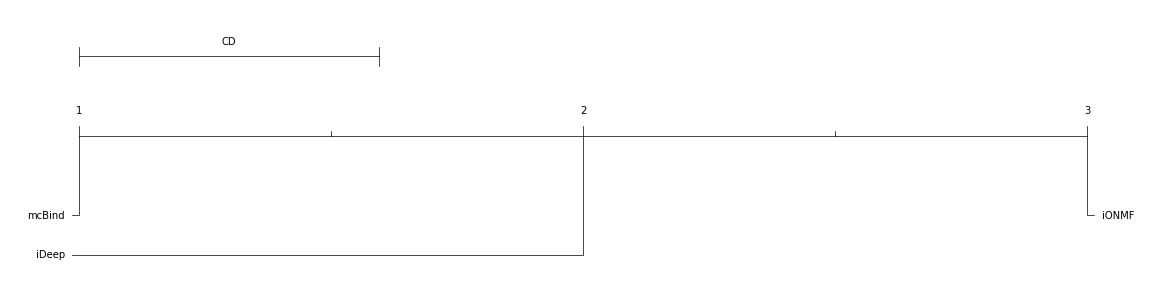

In [14]:
import Orange

ranks = table.rank(axis=1, method="min", ascending=False)
avranks = ranks.mean()
names = table.columns.to_list()
cd = Orange.evaluation.compute_CD(avranks, 31)
Orange.evaluation.graph_ranks(avranks, names, cd=cd, width=16, textspace=1)

fig = plt.gcf()
fig.set_size_inches(16, 4)

plt.savefig("results/critical_difference.png")
plt.show()